In [11]:
#@title Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [2]:
#@title Synthetic data
def set_npseed(seed):
  np.random.seed(seed)
  random.seed(seed)

def set_torchseed(seed):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  

def data_gen(num_train_data,num_vali_data,num_test_data,dim=2,seed=0):
  # np.random.seed(6790)
  set_npseed(seed = seed)
  d=dim
  num_modes=2*d
  centers = np.concatenate((np.eye(d), -1*np.eye(d)), axis=0)
  np.random.shuffle(centers)
  # np.random.seed(475)
  hard=num_modes//2

  a=[4]* hard + [1]*(num_modes - hard)
  mode_frac = np.array([1./num_modes]*num_modes)
  b=1.
  num_train_data = num_train_data 
  num_vali_data=num_vali_data
  num_test_data=num_test_data
  num_data = num_train_data + num_vali_data + num_test_data

  num_data_per_mode = np.int32(num_data*mode_frac)
  num_data_per_mode = np.concatenate((num_data_per_mode,[np.sum(num_data_per_mode)]))

  landmarks=[-1]*num_modes
  labels=[-1]*num_modes
  for i in range(num_modes):
    landmarks[i] = 0.05*np.random.randn(a[i],d)
    landmarks[i]+=centers[i]
    labels[i] = (i - np.arange(len(landmarks[i])))%2
      
  data=[-1]*num_modes
  data_labels=[-1]*num_modes

  train_data=[-1]*num_modes
  train_data_labels=[-1]*num_modes

  test_data=[-1]*num_modes
  test_data_labels=[-1]*num_modes

  vali_data=[-1]*num_modes
  vali_data_labels=[-1]*num_modes


  modes_data=[]
  # np.random.seed(12345)

  for i in range(num_modes):
    data[i] = 0.1*np.random.randn(num_data_per_mode[i],d)
    data[i] += centers[i]
    data_labels[i] = np.zeros(num_data_per_mode[i])
    for j in range(len(data_labels[i])):
      dists = pairwise_distances(data[i][j:j+1,:],landmarks[i])                                   
      j_star = np.argmin(dists[0])
      data_labels[i][j]=labels[i][j_star]
      
      train_data[i] = np.array(data[i][:int(mode_frac[i]*num_train_data)])
      train_data_labels[i] = np.array(data_labels[i][:int(mode_frac[i]*num_train_data)])

      vali_data[i] = np.array(data[i][int(mode_frac[i]*num_train_data): \
                                      int(mode_frac[i]*num_train_data)+int(mode_frac[i]*num_vali_data)])
      vali_data_labels[i] = np.array(data_labels[i][int(mode_frac[i]*num_train_data): \
                                      int(mode_frac[i]*num_train_data)+int(mode_frac[i]*num_vali_data)])

      test_data[i] = np.array(data[i][-int(mode_frac[i]*num_test_data):])
      test_data_labels[i] = np.array(data_labels[i][-int(mode_frac[i]*num_test_data):])
      
  return data,data_labels,train_data,train_data_labels,test_data,test_data_labels,vali_data,vali_data_labels,landmarks,labels,centers,mode_frac

In [3]:
#@title DLGN_FC
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

class DLGN_FC(nn.Module):
  def __init__(self, to_copy=None, num_hidden_layers=0, input_dim=2, output_dim=1, num_hidden_nodes=[], beta=20, mode='pwc'):
    super(DLGN_FC, self).__init__()
    if to_copy==None:
      self.gating_layers=[]
      self.value_layers=[]
      self.num_hidden_layers = num_hidden_layers
      self.beta=beta  # Soft gating parameter
      self.mode = mode
      self.num_nodes=[input_dim]+num_hidden_nodes+[output_dim]
      for i in range(num_hidden_layers+1):
        self.gating_layers.append(nn.Linear(self.num_nodes[i], self.num_nodes[i+1]))
        self.value_layers.append(nn.Linear(self.num_nodes[i], self.num_nodes[i+1], bias=False))
    else:
      self.gating_layers=[]
      self.value_layers=[]
      self.num_hidden_layers = to_copy.num_hidden_layers
      self.beta=to_copy.beta  # Soft gating parameter
      self.mode = to_copy.mode
      self.num_nodes=list(to_copy.num_nodes)
      for i in range(self.num_hidden_layers+1):
        self.gating_layers.append(nn.Linear(self.num_nodes[i], self.num_nodes[i+1]))
        self.value_layers.append(nn.Linear(self.num_nodes[i], self.num_nodes[i+1], bias=False))
        self.gating_layers[i].weight.data =  torch.Tensor(np.array(to_copy.gating_layers[i].weight.detach().numpy()))
        self.gating_layers[i].bias.data = torch.Tensor(np.array(to_copy.gating_layers[i].bias.detach().numpy()))
        self.value_layers[i].weight.data = torch.Tensor(np.array(to_copy.value_layers[i].weight.detach().numpy()))

                

  def return_gating_functions(self):
    effective_weights = []
    effective_biases =[]
    for i in range(self.num_hidden_layers):
      curr_weight = self.gating_layers[i].weight
      curr_bias = self.gating_layers[i].bias
      if i==0:
        effective_weights.append(curr_weight)
        effective_biases.append(curr_bias)
      else:
        effective_biases.append(torch.matmul(curr_weight,effective_biases[-1])+curr_bias)
        effective_weights.append(torch.matmul(curr_weight,effective_weights[-1]))
    return effective_weights, effective_biases
    # effective_weights (and effective biases) is a list of size num_hidden_layers
              

  def forward(self, x):
    gate_scores=[x]
    if self.mode=='pwc':
      values=[torch.ones(x.shape)]
    else:
      values=[x]
    
    for i in range(self.num_hidden_layers):
      gate_scores.append(self.gating_layers[i](gate_scores[-1]))
      curr_gate_on_off = torch.sigmoid(self.beta*gate_scores[-1])
      values.append(self.value_layers[i](values[-1])*curr_gate_on_off)
    values.append(self.value_layers[self.num_hidden_layers](values[-1]))
    # Values is a list of size 1+num_hidden_layers+1
    #gate_scores is a list of size 1+num_hidden_layers
    return values,gate_scores
    
    

Using cpu device


In [ ]:
#@title Kernel Functions
def get_overlap_kernel_DLGN(data_x, DLGN_obj):
  values,gate_scores = DLGN_obj.forward(data_x)
  n = len(data_x)
  overlap_kernel = torch.ones((n,n))
  for g in gate_scores:
      curr = torch.matmul(g,g.T)
      overlap_kernel *= curr
  return overlap_kernel.detach().numpy()
               
def get_tangent_kernel_DLGN(data_x, DLGN_obj):
  values,gate_scores = DLGN_obj.forward(data_x)
  out = values[-1]
  n = len(data_x)
  DLGN_params = []
  DLGN_params += [item.weight for item in DLGN_obj.gating_layers[:-1]]
  DLGN_params += [item.bias for item in DLGN_obj.gating_layers[:-1]]
  DLGN_params += [item.weight for item in DLGN_obj.value_layers]

  tangent_kernel = torch.zeros((n,n))
  grad_feats_all = []
  for i in range(n):
      curr_grads = torch.autograd.grad(out[i], DLGN_params, retain_graph=True, allow_unused=True)
      curr_grads = [element.detach().numpy() for element in curr_grads]
      grad_feats_all.append(curr_grads)
      
  NTK = np.zeros((len(grad_feats_all),len(grad_feats_all)))
  for i in range(len(grad_feats_all)):
      for j in range(len(grad_feats_all)):
          NTK[i,j] = sum_of_elementwise_products(grad_feats_all[i], grad_feats_all[j])
  return NTK 

In [ ]:
#@title Train DLGN
# def train_dlgn(seed,num_hidden_layers,input_dim,output_dim,num_hidden_nodes,beta,
#                mode,train_data_curr,vali_data_curr,test_data_curr,train_labels_curr,test_labels_curr,vali_labels_curr,num_epoch):
#   # torch.random.manual_seed(1222)
#   # torch.random.manual_seed(2311)
#   set_torchseed(seed)
#   DLGN_obj = None
#   DLGN_obj_return = None

#   DLGN_obj = DLGN_FC(num_hidden_layers=num_hidden_layers, input_dim=input_dim, output_dim=output_dim, 
#                       num_hidden_nodes=num_hidden_nodes, beta=beta, mode=mode)
#   DLGN_obj_return = DLGN_FC(to_copy=DLGN_obj)
#   criterion = nn.CrossEntropyLoss()
#   DLGN_params = []
#   DLGN_params += [item.weight for item in DLGN_obj.gating_layers]
#   DLGN_params += [item.bias for item in DLGN_obj.gating_layers]
#   DLGN_params += [item.weight for item in DLGN_obj.value_layers]
# #     DLGN_params += [item.bias for item in DLGN_obj.value_layers]

#   optimizer = optim.Adam(DLGN_params, lr=0.00005, weight_decay=0.0)
  
  
#   train_data_torch = torch.Tensor(train_data_curr)
#   vali_data_torch = torch.Tensor(vali_data_curr)
#   test_data_torch = torch.Tensor(test_data_curr)

#   train_labels_torch = torch.tensor(train_labels_curr, dtype=torch.int64)
#   test_labels_torch = torch.tensor(test_labels_curr, dtype=torch.int64)
#   vali_labels_torch = torch.tensor(vali_labels_curr, dtype=torch.int64)

#   batch_size = len(train_data_curr)
#   losses=[]
#   DLGN_obj_store = []
#   num_batches = len(train_data_curr)//batch_size
#   best_vali_error = len(vali_labels_curr)
  
#   for epoch in tqdm(range(num_epoch)):  # loop over the dataset multiple times
#     running_loss = 0.0
#     if epoch%10==0:
#       DLGN_obj_store.append(DLGN_FC(to_copy=DLGN_obj))
    
#     for batch_start in range(0,len(train_data_curr),batch_size):
#       optimizer.zero_grad()
#       values,gate_scores = DLGN_obj(train_data_torch[batch_start:batch_start+batch_size])
#       outputs = torch.cat((values[-1], -1*values[-1]), dim=1)
#       loss = criterion(outputs, train_labels_torch[batch_start:batch_start+batch_size])
#       loss.backward()
#       optimizer.step()
#       running_loss += loss.item()    
#     losses.append(running_loss/num_batches)

#     values,gate_scores =DLGN_obj(vali_data_torch)
#     vali_preds = torch.cat((values[-1], -1*values[-1]), dim=1)
#     vali_error= torch.sum(vali_labels_torch!=torch.argmax(vali_preds, dim=1)).numpy()
    
#     if vali_error < best_vali_error:
#       DLGN_obj_return = DLGN_FC(to_copy=DLGN_obj)
#       best_vali_error = vali_error
    
#   values,gate_scores =DLGN_obj_return(test_data_torch)
#   test_preds = torch.cat((values[-1], -1*values[-1]), dim=1)
#   test_error= torch.sum(test_labels_torch!=torch.argmax(test_preds, dim=1)).numpy()

  
  
#   values,gate_scores=DLGN_obj_return(train_data_torch)
#   train_preds = torch.cat((values[-1], -1*values[-1]), dim=1)
#   train_error= torch.sum(train_labels_torch!=torch.argmax(train_preds, dim=1)).numpy()
#   plt.figure()
#   plt.title("DLGN loss vs epoch")
#   plt.plot(losses)
#   return test_error, train_error, torch.argmax(test_preds, dim=1).numpy(), DLGN_obj_return, DLGN_obj_store

In [ ]:
#@title Train DLGN model based on freeze variable
def train_dlgn(seed,num_hidden_layers,input_dim,output_dim,num_hidden_nodes,beta,no_of_batches,
               mode,layer_num,node_num,train_data_curr,vali_data_curr,test_data_curr,train_labels_curr,test_labels_curr,vali_labels_curr,num_epoch,freeze):
  # torch.random.manual_seed(1222)
  # torch.random.manual_seed(2311)
  set_torchseed(seed)
  if freeze:
    DLGN_obj_initial = None
  DLGN_obj = None
  DLGN_obj_return = None
  
  DLGN_obj = DLGN_FC(num_hidden_layers=num_hidden_layers, input_dim=input_dim, output_dim=output_dim, 
                      num_hidden_nodes=num_hidden_nodes, beta=beta, mode=mode)
  if freeze:
    DLGN_obj_initial = DLGN_FC(to_copy=DLGN_obj)
  
  DLGN_obj_return = DLGN_FC(to_copy=DLGN_obj)

  criterion = nn.CrossEntropyLoss()
  DLGN_params = []
  DLGN_params += [item.weight for item in DLGN_obj.gating_layers]
  DLGN_params += [item.bias for item in DLGN_obj.gating_layers]
  DLGN_params += [item.weight for item in DLGN_obj.value_layers]
#     DLGN_params += [item.bias for item in DLGN_obj.value_layers]

  # print("H0")
  # print(DLGN_params)
  if freeze:
    count = 0
    for param in DLGN_params:
      if(count != layer_num):
        param.requires_grad=False
      count=count+1

  # print("H1")
  # print(DLGN_params)

  optimizer = optim.Adam(DLGN_params, lr=0.00005, weight_decay=0.0)
  

  # print("H2")
  # print(DLGN_params)
  
  train_data_torch = torch.Tensor(train_data_curr)
  vali_data_torch = torch.Tensor(vali_data_curr)
  test_data_torch = torch.Tensor(test_data_curr)

  train_labels_torch = torch.tensor(train_labels_curr, dtype=torch.int64)
  test_labels_torch = torch.tensor(test_labels_curr, dtype=torch.int64)
  vali_labels_torch = torch.tensor(vali_labels_curr, dtype=torch.int64)
  num_batches = no_of_batches
  batch_size = len(train_data_curr)//num_batches
  losses=[]
  DLGN_obj_store = []
  best_vali_error = len(vali_labels_curr)

  # print("H3")
  # print(DLGN_params)

  for epoch in tqdm(range(num_epoch)):  # loop over the dataset multiple times
    running_loss = 0.0
    if epoch%10==0:
      DLGN_obj_store.append(DLGN_FC(to_copy=DLGN_obj))
    
    for batch_start in range(0,len(train_data_curr),batch_size):
      optimizer.zero_grad()
      values,gate_scores = DLGN_obj(train_data_torch[batch_start:batch_start+batch_size])
      outputs = torch.cat((values[-1], -1*values[-1]), dim=1)
      loss = criterion(outputs, train_labels_torch[batch_start:batch_start+batch_size])

      # print("H4")
      # print(DLGN_params)

      loss.backward()
      optimizer.step()

      # print("H5")
      # print(DLGN_params)
      if freeze:
        for node in range(num_hidden_nodes[layer_num]):
          if(node!=node_num):
            # self.gating_layers[i].weight.data =  torch.Tensor(np.array(to_copy.gating_layers[i].weight.detach().numpy()))
            DLGN_params[layer_num].data[node]= DLGN_obj_initial.gating_layers[layer_num].weight.data[node]

      # print("H6")
      # print(DLGN_params)

      running_loss += loss.item()    
    losses.append(running_loss/num_batches)

    values,gate_scores =DLGN_obj(vali_data_torch)
    vali_preds = torch.cat((values[-1], -1*values[-1]), dim=1)
    vali_error= torch.sum(vali_labels_torch!=torch.argmax(vali_preds, dim=1)).numpy()
    
    if vali_error < best_vali_error:
      DLGN_obj_return = DLGN_FC(to_copy=DLGN_obj)
      best_vali_error = vali_error
    
  values,gate_scores =DLGN_obj_return(test_data_torch)
  test_preds = torch.cat((values[-1], -1*values[-1]), dim=1)
  test_error= torch.sum(test_labels_torch!=torch.argmax(test_preds, dim=1)).numpy()

  
  
  values,gate_scores=DLGN_obj_return(train_data_torch)
  train_preds = torch.cat((values[-1], -1*values[-1]), dim=1)
  train_error= torch.sum(train_labels_torch!=torch.argmax(train_preds, dim=1)).numpy()
  plt.figure()
  plt.title("DLGN loss vs epoch")
  plt.plot(losses)
  return test_error, train_error, torch.argmax(test_preds, dim=1).numpy(), DLGN_obj_return, DLGN_obj_store

**Generating data**

In [4]:
num_train_data=2400
num_vali_data=2400
num_test_data=2400
dim=2
num_modes=2*dim
seed=365
data,data_labels,train_data,train_data_labels,test_data,test_data_labels,vali_data,vali_data_labels, \
landmarks,labels,centers,mode_frac= data_gen(num_train_data,num_vali_data,num_test_data,dim=2,seed=0)

In [8]:
train_data[0].shape

(600, 2)

**Plotting the data**

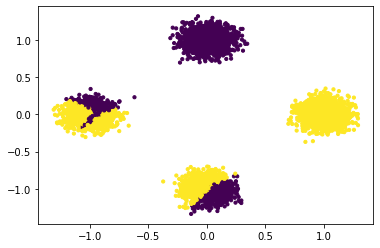

In [ ]:
plt.scatter(np.concatenate(data)[:,0], np.concatenate(data)[:,1], c=np.concatenate(data_labels), s=10)

**Training a DLGN model**

________________________________
=======Training on mode:  0
________________________________
Num Train =  600
Num Vali  =  600
Num Test  =  600
==========DLGN===========


100%|██████████| 20000/20000 [03:43<00:00, 89.58it/s] 


________________________________
=======Training on mode:  1
________________________________
Num Train =  600
Num Vali  =  600
Num Test  =  600
==========DLGN===========


100%|██████████| 20000/20000 [03:32<00:00, 94.01it/s]


________________________________
=======Training on mode:  2
________________________________
Num Train =  600
Num Vali  =  600
Num Test  =  600
==========DLGN===========


100%|██████████| 20000/20000 [03:32<00:00, 94.14it/s] 


________________________________
=======Training on mode:  3
________________________________
Num Train =  600
Num Vali  =  600
Num Test  =  600
==========DLGN===========


100%|██████████| 20000/20000 [03:33<00:00, 93.85it/s]


________________________________
=======Training on mode:  4
________________________________
Num Train =  2400
Num Vali  =  2400
Num Test  =  2400
==========DLGN===========


100%|██████████| 20000/20000 [03:57<00:00, 84.32it/s]


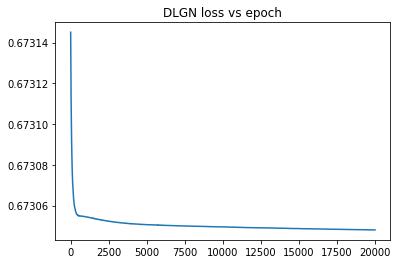

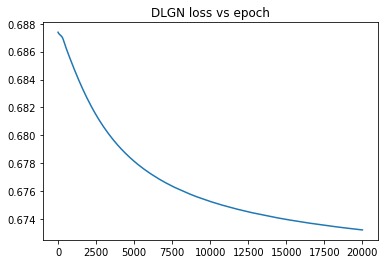

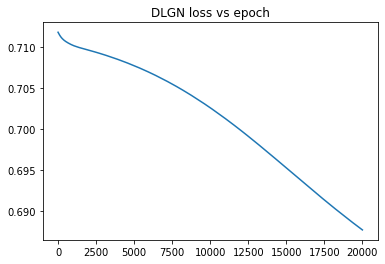

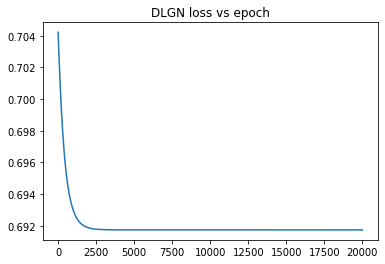

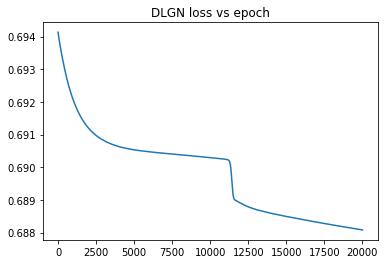

In [ ]:
seed=0
num_hidden_layers=3
input_dim=dim
output_dim=1
num_hidden_nodes=[3,3,3]
beta=20
no_of_batches=10 #[1,10,100]
modep='pwc'

freeze = True
layer_num = 1
node_num = 1

num_epoch=20000
test_err_dlgn = np.zeros(num_modes+1)
train_err_dlgn = np.zeros(num_modes+1)
predictions_dlgnm = [0]*(num_modes+1)
DLGN_obj_final_dlgn = [0]*(num_modes+1)
DLGN_obj_store_dlgn = [0]*(num_modes+1)

for mode in range(num_modes+1): #[num_modes]: 
  print("________________________________")
  print("=======Training on mode: ", mode)
  print("________________________________")        

  if mode<num_modes:
    train_data_curr = train_data[mode]
    train_labels_curr = train_data_labels[mode]
    vali_data_curr = vali_data[mode]
    vali_labels_curr = vali_data_labels[mode]
    test_data_curr = test_data[mode]
    test_labels_curr = test_data_labels[mode]
      
      
  if mode==num_modes:
    train_data_curr = np.concatenate(train_data[0:num_modes])
    train_labels_curr = np.concatenate(train_data_labels[0:num_modes])
    vali_data_curr = np.concatenate(vali_data[0:num_modes])
    vali_labels_curr = np.concatenate(vali_data_labels[0:num_modes])
    test_data_curr = np.concatenate(test_data[0:num_modes])
    test_labels_curr = np.concatenate(test_data_labels[0:num_modes])

  print("Num Train = ",len(train_data_curr))
  print("Num Vali  = ",len(vali_data_curr))
  print("Num Test  = ",len(test_data_curr))
  print("==========DLGN===========")   


  test_error, train_error, predictions_dlgn, DLGN_obj_final, DLGN_obj_store = train_dlgn(seed,num_hidden_layers,input_dim,output_dim,num_hidden_nodes,beta,
               no_of_batches,modep,layer_num,node_num,train_data_curr,vali_data_curr,test_data_curr,train_labels_curr,test_labels_curr,vali_labels_curr,num_epoch,freeze)
  
  train_err_dlgn[mode] = train_error
  test_err_dlgn[mode] = test_error
  predictions_dlgnm[mode] = predictions_dlgn
  DLGN_obj_final_dlgn[mode] = DLGN_obj_final
  DLGN_obj_store_dlgn[mode] = DLGN_obj_store

**Check node freezing**

In [ ]:
epoch=len(DLGN_obj_store_dlgn[4])
value = np.zeros((epoch,3,3))

for index,model in enumerate(DLGN_obj_store_dlgn[4]):
  for i in range(len(model.gating_layers)-1):
    for j in range(len(model.gating_layers[i].weight)):
      value[index][i][j]=model.gating_layers[i].weight[j].data.detach().numpy().mean(axis=0)

In [ ]:
epoch_count=range(epoch)

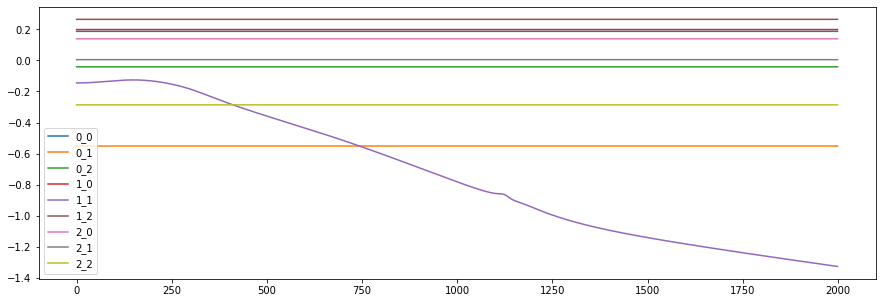

In [ ]:
plt.figure(figsize=(15, 5))
for i in range(value[0].shape[0]):
  for j in range(value[0].shape[1]):
    plt.plot(epoch_count,value[:,i,j],label=str(i)+"_"+str(j))
    plt.legend()

In [ ]:
value[0].shape

In [ ]:
print("=====DLGN=====")
print(test_err_dlgn)
print(train_err_dlgn)
# print(test_err_dlgn[:-1].sum())

In [ ]:
print(predictions_dlgnm[num_modes])
print(test_labels_curr)
print('======== Total =========')
print('Total DLGN acc=')
print(np.sum(predictions_dlgnm[num_modes]==test_labels_curr))

mode_starts = np.int32(np.cumsum(mode_frac*num_test_data))
mode_starts = np.concatenate(([0], mode_starts))
print('========DLGN=========')

for mode in range(num_modes):
    print(np.sum(predictions_dlgnm[num_modes][mode_starts[mode]:mode_starts[mode+1]]== \
                 test_labels_curr[mode_starts[mode]:mode_starts[mode+1]]))

**Data vs prediction scatter plot**

In [ ]:
for mode in range(num_modes+1): #[num_modes]: 
  print("________________________________")
  print("=======Training on mode: ", mode)
  print("________________________________")        

  if mode<num_modes:
    train_data_curr = train_data[mode]
    train_labels_curr = train_data_labels[mode]
    vali_data_curr = vali_data[mode]
    vali_labels_curr = vali_data_labels[mode]
    test_data_curr = test_data[mode]
    test_labels_curr = test_data_labels[mode]
      
      
  if mode==num_modes:
    train_data_curr = np.concatenate(train_data[0:num_modes])
    train_labels_curr = np.concatenate(train_data_labels[0:num_modes])
    vali_data_curr = np.concatenate(vali_data[0:num_modes])
    vali_labels_curr = np.concatenate(vali_data_labels[0:num_modes])
    test_data_curr = np.concatenate(test_data[0:num_modes])
    test_labels_curr = np.concatenate(test_data_labels[0:num_modes])

  # print("Num Train = ",len(train_data_curr))
  # print("Num Vali  = ",len(vali_data_curr))
  print("Num Test  = ",len(test_data_curr))
  # print("==========DLGN===========")   
  plt.figure()
  plt.subplot(1, 2, 1) # row 1, col 2 index 1
  plt.scatter(test_data_curr[:,0], test_data_curr[:,1], c=test_labels_curr)
  plt.title("Real labelled test data")


  plt.subplot(1, 2, 2) # index 2
  plt.scatter(test_data_curr[:,0], test_data_curr[:,1], c=predictions_dlgnm[mode])
  plt.title("Predicted Labelled test data")
  plt.show()
  

  # plt.scatter(test_data_curr[:,0],test_data_curr[:,1],predictions_dlgnm[mode], levels=100)
  # plt.colorbar()


**Gating pattern per layer with best model**

In [ ]:
for mode in range(num_modes+1): #[num_modes]: 
 
  if mode<num_modes:
    train_data_curr = train_data[mode]
    train_labels_curr = train_data_labels[mode]
    vali_data_curr = vali_data[mode]
    vali_labels_curr = vali_data_labels[mode]
    test_data_curr = test_data[mode]
    test_labels_curr = test_data_labels[mode]
      
      
  if mode==num_modes:
    train_data_curr = np.concatenate(train_data[0:num_modes])
    train_labels_curr = np.concatenate(train_data_labels[0:num_modes])
    vali_data_curr = np.concatenate(vali_data[0:num_modes])
    vali_labels_curr = np.concatenate(vali_data_labels[0:num_modes])
    test_data_curr = np.concatenate(test_data[0:num_modes])
    test_labels_curr = np.concatenate(test_data_labels[0:num_modes])

  effective_weights, effective_biases = DLGN_obj_final_dlgn[mode].return_gating_functions()
  X=test_data_curr[:,0]
  Y=test_data_curr[:,1]

  #calculating the gating patterns
  gating_pattern_list=[]
  for j in range(num_hidden_layers):
      Z_all = np.zeros(X.shape)
      for i in range( num_hidden_nodes[j]):
          weight = effective_weights[j][i].data.numpy()
          bias = effective_biases[j][i].data.numpy()
          Z = (np.dot(weight,test_data_curr.T)+bias)>0
          Z = Z.reshape(X.shape)
          Z_all+=(2**i)*Z
      gating_pattern_list.append(Z_all)

  #plotting the gating paterns
  fig,ax=plt.subplots(1, num_hidden_layers+2,sharex=True, sharey=True,figsize=(15, 3)) # row 1, col n
  fig.tight_layout(pad=2)
  fig.text(0,0,s=str(mode)+" Mode")
  
  im0=ax[0].scatter(test_data_curr[:,0], test_data_curr[:,1], c=test_labels_curr)
  divider = make_axes_locatable(ax[0])
  cax = divider.append_axes('right', size='5%', pad=0.05)
  fig.colorbar(im0, cax=cax, orientation='vertical')
  ax[0].title.set_text("Real")

  im1=ax[1].scatter(test_data_curr[:,0], test_data_curr[:,1], c=predictions_dlgnm[mode])
  divider = make_axes_locatable(ax[1])
  cax = divider.append_axes('right', size='5%', pad=0.05)
  fig.colorbar(im1, cax=cax, orientation='vertical')
  ax[1].title.set_text("Predicted")

  for j in range(num_hidden_layers):    
      im=ax[j+2].scatter(test_data_curr[:,0], test_data_curr[:,1], c=gating_pattern_list[j])
      divider = make_axes_locatable(ax[j+2])
      cax = divider.append_axes('right', size='5%', pad=0.05)
      fig.colorbar(im, cax=cax, orientation='vertical')

      if j==1:
        text = str(j)+"st layer"
      elif j==2:
        text = str(j)+"nd layer"
      else:
        text=str(j)+"th layer"
      ax[j+2].title.set_text(text)

  # Stands for dots per inch, 300 is very high quality
  fig.savefig("Mode_"+str(mode)+"_layer_"+str(j)+"_.png", dpi=300)
  # Control image quality with percentage
  # fig.savefig('sample.jpg', quality=50)


  # fig.subplots_adjust(right=0.8)
  # cbar_ax = fig.add_axes([0.85, 0.12, 0.01, 0.82])
  # fig.colorbar(im, cax=cbar_ax)

  plt.show()


**Change of gating pattern for each layers per 10 epoch**

In [ ]:
# Python program to check whether the given
def perfectCube(N) :
	cube_root = round(N**(1/3));
	if cube_root * cube_root * cube_root == N :
		return True;
	else :
		return False;

In [ ]:
path="/content/drive/MyDrive/Research/DLGN_fixed_node/Gating_features/"

In [ ]:

for mode in range(num_modes+1): #[num_modes]: 
  for model_no in range(len(DLGN_obj_store_dlgn[mode])):
    if perfectCube(model_no):
      print("________________________________")
      print("=======Model no: ", model_no)
      print("________________________________")

      if mode<num_modes:
        train_data_curr = train_data[mode]
        train_labels_curr = train_data_labels[mode]
        vali_data_curr = vali_data[mode]
        vali_labels_curr = vali_data_labels[mode]
        test_data_curr = test_data[mode]
        test_labels_curr = test_data_labels[mode]
          
          
      if mode==num_modes:
        train_data_curr = np.concatenate(train_data[0:num_modes])
        train_labels_curr = np.concatenate(train_data_labels[0:num_modes])
        vali_data_curr = np.concatenate(vali_data[0:num_modes])
        vali_labels_curr = np.concatenate(vali_data_labels[0:num_modes])
        test_data_curr = np.concatenate(test_data[0:num_modes])
        test_labels_curr = np.concatenate(test_data_labels[0:num_modes])

      effective_weights, effective_biases = DLGN_obj_store_dlgn[mode][model_no].return_gating_functions()
      X=test_data_curr[:,0]
      Y=test_data_curr[:,1]

      #calculating the gating patterns
      gating_pattern_list=[]
      for j in range(num_hidden_layers):
          Z_all = np.zeros(X.shape)
          for i in range( num_hidden_nodes[j]):
              weight = effective_weights[j][i].data.numpy()
              bias = effective_biases[j][i].data.numpy()
              Z = (np.dot(weight,test_data_curr.T)+bias)>0
              Z = Z.reshape(X.shape)
              Z_all+=(2**i)*Z
          gating_pattern_list.append(Z_all)

      #plotting the gating paterns
      fig,ax=plt.subplots(1, num_hidden_layers+2,sharex=True, sharey=True,figsize=(15, 3)) # row 1, col n
      fig.tight_layout(pad=2)
      fig.text(0,0,s="Mode no: "+str(mode)+"Model no: "+str(model_no))
      
      im0=ax[0].scatter(test_data_curr[:,0], test_data_curr[:,1], c=test_labels_curr)
      divider = make_axes_locatable(ax[0])
      cax = divider.append_axes('right', size='5%', pad=0.05)
      fig.colorbar(im0, cax=cax, orientation='vertical')
      ax[0].title.set_text("Real")

      im1=ax[1].scatter(test_data_curr[:,0], test_data_curr[:,1], c=predictions_dlgnm[mode])
      divider = make_axes_locatable(ax[1])
      cax = divider.append_axes('right', size='5%', pad=0.05)
      fig.colorbar(im1, cax=cax, orientation='vertical')
      ax[1].title.set_text("Predicted")

      for j in range(num_hidden_layers):    
          im=ax[j+2].scatter(test_data_curr[:,0], test_data_curr[:,1], c=gating_pattern_list[j])
          divider = make_axes_locatable(ax[j+2])
          cax = divider.append_axes('right', size='5%', pad=0.05)
          fig.colorbar(im, cax=cax, orientation='vertical')

          if j==1:
            text = str(j)+"st layer"
          elif j==2:
            text = str(j)+"nd layer"
          else:
            text=str(j)+"th layer"
          ax[j+2].title.set_text(text)

      # Stands for dots per inch, 300 is very high quality
      # fig.savefig('sample.png', dpi=300)
      fig.savefig(str(path)+"Mode_"+str(mode)+"_epoch_"+str(model_no)+"_.png", dpi=300)

      # Control image quality with percentage
      # fig.savefig('sample.jpg', quality=50)


      # fig.subplots_adjust(right=0.8)
      # cbar_ax = fig.add_axes([0.85, 0.12, 0.01, 0.82])
      # fig.colorbar(im, cax=cbar_ax)

      plt.show()


In [ ]:
mode_losses = np.zeros((len(DLGN_obj_store_dlgn[0]), num_modes+1))
criterion = nn.CrossEntropyLoss()


for mode in range(num_modes+1):

  print("________________________________")
  print("=======Testing on mode: ", mode)
  print("________________________________")        

  if mode<num_modes:
    train_data_curr = train_data[mode]
    train_labels_curr = train_data_labels[mode]
    vali_data_curr = vali_data[mode]
    vali_labels_curr = vali_data_labels[mode]
    test_data_curr = test_data[mode]
    test_labels_curr = test_data_labels[mode]
        
  if mode==num_modes:
    train_data_curr = np.concatenate(train_data[0:num_modes])
    train_labels_curr = np.concatenate(train_data_labels[0:num_modes])
    vali_data_curr = np.concatenate(vali_data[0:num_modes])
    vali_labels_curr = np.concatenate(vali_data_labels[0:num_modes])
    test_data_curr = np.concatenate(test_data[0:num_modes])
    test_labels_curr = np.concatenate(test_data_labels[0:num_modes])

  for index, item in enumerate(DLGN_obj_store_dlgn[mode]):
    # print(index, item)
    halfspaces = item.return_gating_functions()
    X = torch.tensor(test_data_curr, dtype = torch.float32)
    y = torch.tensor(test_labels_curr, dtype=torch.int64)
    values,gate_scores=item(X)
    preds = torch.cat((values[-1], -1*values[-1]), dim=1)
    # print(torch.argmax(preds, dim=1))
    # print(y)
    error= torch.sum(y!=torch.argmax(preds, dim=1)).numpy()
    loss = criterion(preds, y)
    mode_losses[index, mode] = loss
    
    # plt.figure()
    # plt.title('Epoch '+str(index)+' : Layer 1')
    # plt.plot(halfspaces[0][0].detach().numpy().T, 'r-')
    # plt.figure()
    # plt.title('Epoch '+str(index)+' : Layer 2')    
    # plt.plot(halfspaces[0][1].detach().numpy().T, 'r-')
    # plt.figure()
    # plt.title('Epoch '+str(index)+' : Layer 3')    
    # plt.plot(halfspaces[0][2].detach().numpy().T, 'r-')
    

# print(halfspaces[0].shape)
# print(halfspaces[1].shape)
# print(halfspaces[2].shape)
# print(halfspaces[3].shape)
# print(halfspaces[4].shape)
# print(halfspaces[5].shape)

________________________________
=======Testing on mode:  0
________________________________
________________________________
=======Testing on mode:  1
________________________________
________________________________
=======Testing on mode:  2
________________________________
________________________________
=======Testing on mode:  3
________________________________
________________________________
=======Testing on mode:  4
________________________________


**Loss plot for all modes**

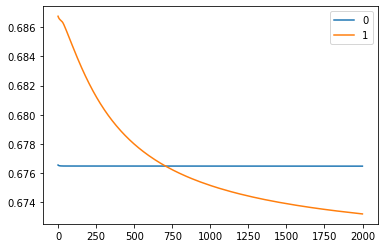

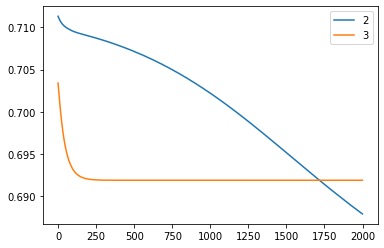

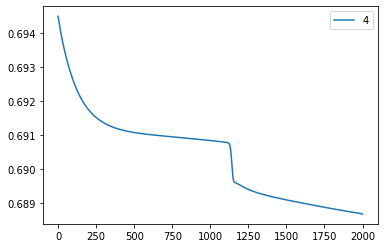

In [ ]:
plt.figure()

for mode in range(num_modes//2):
    plt.plot(mode_losses[:,mode], label=str(mode))
    plt.legend()
    
plt.figure()

for mode in range(num_modes//2, num_modes):
    plt.plot(mode_losses[:,mode], label=str(mode))
    plt.legend()

plt.figure()

for mode in [num_modes]:
    plt.plot(mode_losses[:,mode], label=str(mode))
    plt.legend()

**No_of_path plot for all modes**

In [ ]:
num_epochs_by_ten = len(DLGN_obj_store_dlgn[0])
num_hidden_layers = DLGN_obj_store_dlgn[0][0].num_hidden_layers
num_neurons_per_layer = DLGN_obj_store_dlgn[0][0].num_nodes[1]
gates_on = np.zeros((num_epochs_by_ten, num_modes+1,num_hidden_layers,num_neurons_per_layer))

for layer in range(num_hidden_layers):
  for i in range(num_epochs_by_ten):
    for j in range(num_modes+1):
      values,gate_scores = DLGN_obj_store_dlgn[j][i].forward(torch.Tensor(centers[j%num_modes:j%num_modes+1]))
      gates_on[i,j,layer,:] = torch.sigmoid(beta*gate_scores[layer+1]).detach().numpy().mean(axis=0)

In [ ]:
gates_on[1,1,1,:]

In [ ]:
print(gates_on.shape)

path_on = np.zeros((num_epochs_by_ten, num_modes+1))
for epoch_index in range(num_epochs_by_ten):
  for mode in range(num_modes+1):
    path_on[epoch_index, mode] = np.sum(gates_on[epoch_index, mode,0, :]) *\
                                     np.sum(gates_on[epoch_index, mode,1, :]) *\
                                     np.sum(gates_on[epoch_index, mode,2, :])

(2000, 5, 3, 3)


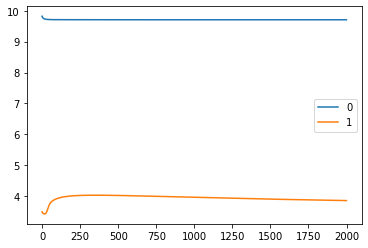

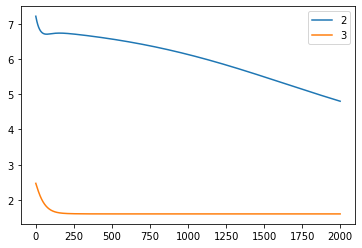

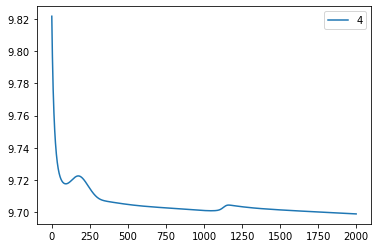

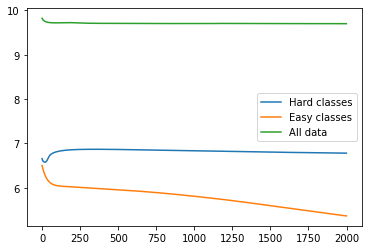

In [ ]:
plt.figure()

for mode in range(num_modes//2):
    plt.plot(path_on[:,mode], label=str(mode))
    plt.legend()
plt.figure()

for mode in range(num_modes//2, num_modes):
    plt.plot(path_on[:,mode], label=str(mode))
    plt.legend()
plt.figure()

for mode in [num_modes]:
    plt.plot(path_on[:,mode], label=str(mode))  
    plt.legend()
plt.figure()
plt.plot(path_on[:,:num_modes//2].mean(axis=1), label='Hard classes')
plt.plot(path_on[:,num_modes//2:].mean(axis=1), label='Easy classes')
plt.plot(path_on[:,num_modes], label='All data')

plt.legend()

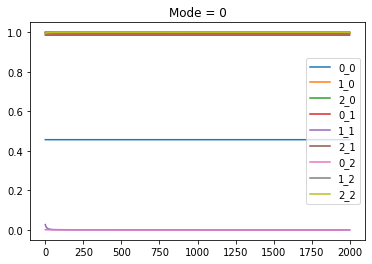

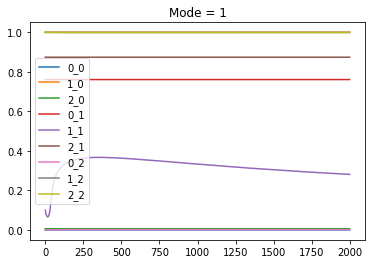

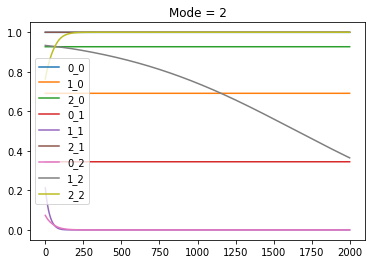

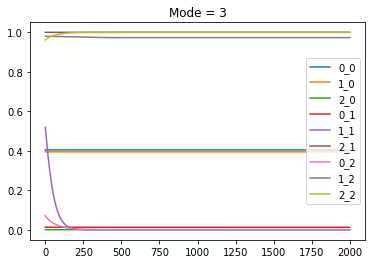

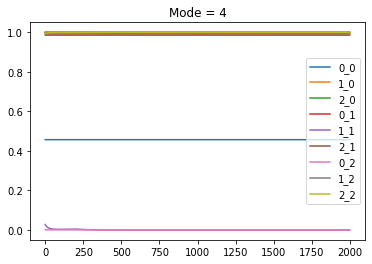

In [ ]:
for mode in range(num_modes+1):
  plt.figure()
  plt.title("Mode = "+str(mode))
  for layer in range(num_hidden_layers):
    for neuron in range(num_neurons_per_layer):
      plt.plot(gates_on[:,mode,layer,neuron],label=str(neuron)+"_"+str(layer))
      plt.legend()

**ROUGH**

In [ ]:
to_copy=None
num_hidden_layers=0
input_dim=2
output_dim=1
num_hidden_nodes=[2,3,4]
beta=20
mode='pwc'
DLGN_obj = DLGN_FC(num_hidden_layers=num_hidden_layers, input_dim=input_dim, output_dim=output_dim, 
                      num_hidden_nodes=num_hidden_nodes, beta=beta, mode=mode)

DLGN_params = []
DLGN_params += [item.weight for item in DLGN_obj.gating_layers]
DLGN_params += [item.bias for item in DLGN_obj.gating_layers]
DLGN_params += [item.weight for item in DLGN_obj.value_layers]
print(DLGN_params)
# print("Hello")
# # Freeze all the parameters except for a specific node
# for name, param in DLGN_obj.named_parameters():
#   print("name:",name)
#   print("param",param)
#   print("Hello1")
# print("Hello2")
    # if name == "2.bias": # this is the node that we want to keep trainable
    #     param.requires_grad = True
    # else:
    #     param.requires_grad = False

# Check that the parameters have been frozen/unfrozen as desired
# for name, param in DLGN_obj.named_parameters():
#     if param.requires_grad:
#         print(f"{name} is trainable")
#     else:
#         print(f"{name} is not trainable")

In [ ]:
model = torch.nn.Sequential(
    torch.nn.Linear(10, 20),
    torch.nn.ReLU(),
    torch.nn.Linear(20, 30),
    torch.nn.ReLU(),
    torch.nn.Linear(30, 40),
    torch.nn.ReLU(),
    torch.nn.Linear(40, 50),v =
    torch.nn.ReLU(),
    torch.nn.Linear(50, 1)
)

print(model)
# print("Hello")
# # Freeze all the parameters except for a specific node
# for name, param in model.named_parameters():
#   print("name:",name)
#   print("param",param)
#   print("Hello1")
# print("Hello2")

In [ ]:
plt.scatter(np.concatenate(data)[:,0], np.concatenate(data)[:,1], c=np.concatenate(data_labels), s=10)

In [ ]:
print(len(train_data))
print(train_data[0].shape)
print(train_data[0][:10])
print(train_data[0].mean(axis=0))

print('=========')
print(landmarks[0])
print(labels[0])
print(centers[0])

In [12]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(2,3)
    self.fc2 = nn.Linear(3,3)
    self.fc3 = nn.Linear(3,1)
  def forward(self,x):
    print("input:",x)
    print("W1:",self.fc1.weight)
    print("B1:",self.fc1.bias)
    x = self.fc1(x)
    print("Y:",x)
    x = self.fc2(x)
    x = self.fc3(x)
    return x


In [13]:
torch.manual_seed(1234)
net =Net()

In [14]:
temp = torch.randn(3,2)


In [21]:
1.5844*-0.6661 + -0.8763*-0.1387 + -0.6339

-1.5677260300000002

In [17]:
y=net(temp)

input: tensor([[ 1.5844, -0.8763],
        [ 0.2811,  1.4718],
        [-0.8330, -0.4121]])
W1: Parameter containing:
tensor([[-0.6661, -0.1387],
        [-0.3396, -0.1886],
        [-0.6247,  0.2838]], requires_grad=True)
B1: Parameter containing:
tensor([-0.6339, -0.0451,  0.2458], requires_grad=True)
Y: tensor([[-1.5677, -0.4179, -0.9926],
        [-1.0253, -0.4181,  0.4879],
        [-0.0218,  0.3156,  0.6492]], grad_fn=<AddmmBackward0>)


In [18]:
temp

tensor([[ 1.5844, -0.8763],
        [ 0.2811,  1.4718],
        [-0.8330, -0.4121]])

In [19]:
net.fc1.weight

Parameter containing:
tensor([[-0.6661, -0.1387],
        [-0.3396, -0.1886],
        [-0.6247,  0.2838]], requires_grad=True)

In [20]:
net.fc1.bias

Parameter containing:
tensor([-0.6339, -0.0451,  0.2458], requires_grad=True)

In [ ]:
temp1=  torch.zeros(3,2)
temp1[0,0] = 1
#print(temp1)
net.fc1.weight.register_hook(lambda grad: torch.multiply(grad,temp1))
net(temp).sum().backward()


In [ ]:
net.fc1.weight.grad

In [ ]:
import torch
v = torch.tensor([0., 0., 0.], requires_grad=True)
h = v.register_hook(lambda grad: grad * 2)  # double the gradient
v.backward(torch.tensor([1., 2., 3.]))
v.grad

In [ ]:
DLGN_obj_final.gating_layers[0].weight[:,0:1].requires_grad=False

In [ ]:
centers[0:1]